<a name='top'></a>Contents
===
- [Introduction](#intro)

- [Libraries](#libraries)

- [Functions](#functions)

- [Settings](#settings)

- [Dataset](#dataset)
      
- [Exploratory data analysis](#exploratory)
    - [Numerical and Categorical data features](#exploratory_features)
    - [Missing values](#exploratory_missing)
    - [Describe Numerical Data](#exploratory_describe_numerical)
    - [Describe Categorical Data](#exploratory_describe_categorical)
    - [Distribution of Target Variable](#distribution_target)
    - [Distribution of logarithm target variable](#distribution_target_log)
    - [Target distribution by categorical values](#distribution_target_categorical)
        - [Target distribution by cat_price](#distribution_target_catprice)
        - [Target distribution by CatN1](#distribution_target_catn1)
    - [Distribution of numerical features](#distribution_columns)
        - [Skewness and kurtosis of numerical features](#skewness_columns)
        - [Logarithm to numerical features](#logarithm_columns)
    - [Distribution of numerical features with target variable](#relation_numerical_columns)
    - [Distribution of categorical features with target variable](#relation_categorical_columns)
    
    
- [Data wrangling](#data_wrangling)
    - [Correlation](#data_correlation)
        - [Correlation of numerical features to target variable](#data_correlation_numerical_original)
        - [Correlation of categorical features to target variable](#data_correlation_categorical_original)
    - [Feature Selection](#data_feature_selection)
        - [Pearson](#data_pearson)
        - [Random Forest](#data_random_forest)    
        - [LGBMRegressor](#data_LGBMRegressor)
        - [Final Feature Selection](#data_final_feature_selection)
    - [Outliers](#outliers)
    - [Correlation feature selection](#correlation_feature_selection)
    - [Distribution of feature selection with target](#distribution_feature_selection)
    - [Multicollinearity](#multicollinearity)
    - [StandardScaler](#standardscaler)
    - [Grade Percentile of target variable](#grade_percentile_target)
    - [Correlation and Distribution final dataset](#distribution_final_dataset)
    

- [Regression Models](#regression_models)


 

------------------------------------------------------------------------------------------------------
<a name='intro'></a>
# Introduction

EXPLICAR TODO Y PONER FOTO

# RELLENAR!!

PASOS CUBIERTOS
    * DATASET
    * EXPLORATORY DATA ANALYSIS
    * DATA WRANGLING
    * ALGORITHMS

-----------------------------------------------------------------------------------
<a name='libraries'></a>
# Libraries

First of all, it is necessary to import the required libraries to develop all the steps correctly of this notebook.

In [1]:
#import standard libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore
from scipy import stats
%matplotlib inline
sns.set()
#from datetime import datetime
#from matplotlib.ticker import PercentFormatter

#import model libraries
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler



#import filter warnings
import warnings
warnings.filterwarnings('ignore')


#display a maximum of 500 columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#set directory of work
path = '/home/miguel/my_project_python/my_project_env/tfm/shopping'
os.chdir(path)

# IMPORTAR LIBRERIAS DE SKLEARN!!!

-----------------------------------------------------------------------------------------------
<a name='functions'></a>
# Functions
In this chapter is run the functions used in this notebook.

In [79]:
#print categorical columns
def columns_categorical(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            print('\nColumn Name:', col,)
            print(df[col].value_counts())
            
            
            
#correlation heatmap
def plot_correlation_heatmap(df, number_columns, arg):
    
    #calculate correlation
    corr = df.corr()
    corr_abs = corr.abs()
    columns = corr_abs.nlargest(number_columns, arg)[arg].index
    cont = np.corrcoef(df[columns].values.T)

    #plot values
    plt.figure(figsize = (number_columns, number_columns))
    sns.set(font_scale = 1.5)
    sns.heatmap(cont, linewidths=1.5, annot=True, square=True, fmt='.2f', 
                annot_kws={'size': 10}, yticklabels=columns.values, xticklabels=columns.values)
    
    #show
    plt.show()
    

#pearson selector
def pearson_selector(feature_name, X, y):
    
    #create empty dataframe
    correlation_list = []
    
    #calculate the correlation for for each feature with target variable
    for i in feature_name:
        corr = np.corrcoef(X[i], y)[0, 1]
        correlation_list.append(corr)
        
    #fillna nan values with 0
    correlation_list = [0 if np.isnan(i) else i for i in correlation_list]
    
    #feature correlation
    corr_feature = X.iloc[:,np.argsort(np.abs(correlation_list))[-20:]].columns.tolist()
    
    #asign value
    corr_support = [True if i in corr_feature else False for i in feature_name]
    
    return corr_support, corr_feature

-----------------------------------------------------------------------------------------------
<a name='settings'></a>
# Settings

It is established the fixed parameters which will be developed in the notebooK.

In [3]:
# set number of cross validations
nr_cv = 5

#set kurtosis and swekness values
kurt = 2
sw = 2

-----------------------------------------------------------------------------------------------
<a name='dataset'></a>
# Dataset

It is opened the dataset of study.

In [4]:
#open the dataset of study
df = pd.read_pickle('./data/final/data_final_ROAS.pkl')

Check the data

In [5]:
df.head()

,CatN1,CatN2,Cat_Price,CPC_medio,CPC_medio_1w,CPC_medio_2w,CPC_medio_3w,CPC_medio_4w,Impressions,Impressions_1w,Impressions_2w,Impressions_3w,Impressions_4w,Clics,Clics_1w,Clics_2w,Clics_3w,Clics_4w,CTR,CTR_1w,CTR_2w,CTR_3w,CTR_4w,Page_Views,Page_Views_1w,Page_Views_2w,Page_Views_3w,Page_Views_4w,Cost,Cost_1w,Cost_2w,Cost_3w,Cost_4w,Conversions,Conversions_1w,Conversions_2w,Conversions_3w,Conversions_4w,All_Conversions,All_Conversions_1w,All_Conversions_2w,All_Conversions_3w,All_Conversions_4w,Ads_Income,Ads_Income_1w,Ads_Income_2w,Ads_Income_3w,Ads_Income_4w,Ads_Income_All,Ads_Income_All_1w,Ads_Income_All_2w,Ads_Income_All_3w,Ads_Income_All_4w,Net_Incomes,Net_Incomes_1w,Net_Incomes_2w,Net_Incomes_3w,Net_Incomes_4w,Units_sold,Units_sold_1w,Units_sold_2w,Units_sold_3w,Units_sold_4w,ROAS_Ads,ROAS
134,muebles,"consolas, recibidores y tocadores",200.0,0.18,0.03,0.01,0.01,0.01,21.0,27.29,13.64,9.10,6.82,2.0,0.29,0.14,0.10,0.07,0.095238,0.02,0.02,0.02,0.02,9.0,22.57,19.29,15.05,12.29,0.35,0.05,0.02,0.02,0.01,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,434.45,104.14,115.19,84.58,69.28,3.0,0.71,0.79,0.57,0.46,0.0,1241.285714
142,muebles,"consolas, recibidores y tocadores",200.0,0.34,0.13,0.08,0.05,0.04,104.0,97.29,64.79,43.19,32.39,4.0,1.71,1.00,0.67,0.50,0.038462,0.03,0.02,0.02,0.02,9.0,22.57,21.93,21.29,17.61,1.35,0.42,0.24,0.16,0.12,0.0,0.04,0.02,0.01,0.01,0.0,0.09,0.04,0.03,0.02,0.0,3.8,1.9,1.27,0.95,0.0,6.13,3.06,2.04,1.53,147.27,21.04,52.07,83.80,68.70,1.0,0.14,0.36,0.57,0.46,0.0,109.088889
160,muebles,"consolas, recibidores y tocadores",200.0,0.12,0.37,0.22,0.25,0.21,402.0,225.57,162.14,155.71,131.82,2.0,1.86,1.64,1.57,1.54,0.004975,0.01,0.01,0.01,0.02,19.0,12.00,16.64,16.86,16.96,0.23,0.66,0.44,0.49,0.44,0.0,0.00,0.00,0.00,0.01,0.0,0.00,0.00,0.00,0.02,0.0,0.0,0.0,0.00,0.95,0.0,0.00,0.00,0.00,1.53,147.27,21.04,10.52,14.03,26.04,1.0,0.14,0.07,0.10,0.18,0.0,640.304348
163,muebles,"consolas, recibidores y tocadores",200.0,0.27,0.34,0.27,0.28,0.24,390.0,291.86,202.50,181.52,160.46,1.0,2.29,1.71,1.67,1.68,0.002564,0.01,0.01,0.01,0.01,9.0,12.00,16.64,14.62,16.61,0.27,0.74,0.53,0.52,0.50,0.0,0.00,0.00,0.00,0.01,0.0,0.00,0.00,0.00,0.02,0.0,0.0,0.0,0.00,0.95,0.0,0.00,0.00,0.00,1.53,139.09,40.91,20.45,13.64,15.49,1.0,0.29,0.14,0.10,0.11,0.0,515.148148
168,muebles,"consolas, recibidores y tocadores",200.0,0.85,0.45,0.37,0.31,0.31,236.0,219.29,227.29,184.43,173.75,2.0,1.43,1.71,1.67,1.61,0.008475,0.01,0.01,0.01,0.01,19.0,16.00,14.00,17.33,15.64,1.70,0.68,0.65,0.55,0.56,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,278.18,79.48,50.26,33.51,30.39,2.0,0.57,0.36,0.24,0.21,0.0,163.635294


In [6]:
df.shape

(782, 65)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 782 entries, 134 to 207
Data columns (total 65 columns):
CatN1                 782 non-null object
CatN2                 782 non-null object
Cat_Price             782 non-null object
CPC_medio             782 non-null float64
CPC_medio_1w          782 non-null float64
CPC_medio_2w          782 non-null float64
CPC_medio_3w          782 non-null float64
CPC_medio_4w          782 non-null float64
Impressions           782 non-null float64
Impressions_1w        782 non-null float64
Impressions_2w        782 non-null float64
Impressions_3w        782 non-null float64
Impressions_4w        782 non-null float64
Clics                 782 non-null float64
Clics_1w              782 non-null float64
Clics_2w              782 non-null float64
Clics_3w              782 non-null float64
Clics_4w              782 non-null float64
CTR                   782 non-null float64
CTR_1w                782 non-null float64
CTR_2w                782 non-null f

-----------------------------------------------------------------------
<a name='exploratory'></a>
# Exploratory data analysis

RELLENAR


<a name='exploratory_features'></a>
## Numerical and Categorical data features

RELLENAR


In [8]:
#number of numerical columns features
numerical_columns = df.dtypes[df.dtypes != 'object'].index
print('Number of NUMERICAL COLUMNS: {} '.format(len(numerical_columns)))

#number of categorical columns features
categorical_columns = df.dtypes[df.dtypes == 'object'].index
print('Number of CATEGORICAL COLUMNS: {} '.format(len(categorical_columns)))

Number of NUMERICAL COLUMNS: 62 
Number of CATEGORICAL COLUMNS: 3 


In [9]:
#names of numerical and categorical columns
print('Numerical columns: {} '.format(df[numerical_columns].columns))
print('-'*228)
print('Categorical columns: {} '.format(df[categorical_columns].columns))

Numerical columns: Index(['CPC_medio', 'CPC_medio_1w', 'CPC_medio_2w', 'CPC_medio_3w',
       'CPC_medio_4w', 'Impressions', 'Impressions_1w', 'Impressions_2w',
       'Impressions_3w', 'Impressions_4w', 'Clics', 'Clics_1w', 'Clics_2w',
       'Clics_3w', 'Clics_4w', 'CTR', 'CTR_1w', 'CTR_2w', 'CTR_3w', 'CTR_4w',
       'Page_Views', 'Page_Views_1w', 'Page_Views_2w', 'Page_Views_3w',
       'Page_Views_4w', 'Cost', 'Cost_1w', 'Cost_2w', 'Cost_3w', 'Cost_4w',
       'Conversions', 'Conversions_1w', 'Conversions_2w', 'Conversions_3w',
       'Conversions_4w', 'All_Conversions', 'All_Conversions_1w',
       'All_Conversions_2w', 'All_Conversions_3w', 'All_Conversions_4w',
       'Ads_Income', 'Ads_Income_1w', 'Ads_Income_2w', 'Ads_Income_3w',
       'Ads_Income_4w', 'Ads_Income_All', 'Ads_Income_All_1w',
       'Ads_Income_All_2w', 'Ads_Income_All_3w', 'Ads_Income_All_4w',
       'Net_Incomes', 'Net_Incomes_1w', 'Net_Incomes_2w', 'Net_Incomes_3w',
       'Net_Incomes_4w', 'Units_sold', 'U

<a name='exploratory_missing'></a>
## Missing values

It is checked if there are missing values in the dataset.

In [10]:
print('Missing values in the dataset: {} '.format(df.isnull().sum().sum()))

Missing values in the dataset: 0 


<a name='exploratory_describe_numerical'></a>
## Describe Numerical Data

RELLENAR


In [11]:
df.describe()

,CPC_medio,CPC_medio_1w,CPC_medio_2w,CPC_medio_3w,CPC_medio_4w,Impressions,Impressions_1w,Impressions_2w,Impressions_3w,Impressions_4w,Clics,Clics_1w,Clics_2w,Clics_3w,Clics_4w,CTR,CTR_1w,CTR_2w,CTR_3w,CTR_4w,Page_Views,Page_Views_1w,Page_Views_2w,Page_Views_3w,Page_Views_4w,Cost,Cost_1w,Cost_2w,Cost_3w,Cost_4w,Conversions,Conversions_1w,Conversions_2w,Conversions_3w,Conversions_4w,All_Conversions,All_Conversions_1w,All_Conversions_2w,All_Conversions_3w,All_Conversions_4w,Ads_Income,Ads_Income_1w,Ads_Income_2w,Ads_Income_3w,Ads_Income_4w,Ads_Income_All,Ads_Income_All_1w,Ads_Income_All_2w,Ads_Income_All_3w,Ads_Income_All_4w,Net_Incomes,Net_Incomes_1w,Net_Incomes_2w,Net_Incomes_3w,Net_Incomes_4w,Units_sold,Units_sold_1w,Units_sold_2w,Units_sold_3w,Units_sold_4w,ROAS_Ads,ROAS
count,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000
mean,0.274092,0.253299,0.243235,0.237391,0.231931,2032.314578,1862.997212,1793.482992,1745.355512,1699.905332,25.974425,23.218376,22.329182,21.538414,20.861944,0.013124,0.012980,0.012903,0.012890,0.012749,40.602302,34.360972,32.654527,31.262238,30.101189,6.838120,5.782442,5.450179,5.240575,5.093133,0.344092,0.205269,0.189731,0.180614,0.171125,0.813056,0.535371,0.522877,0.519680,0.507928,21.092455,11.696138,10.685908,10.158210,9.594041,37.303926,20.904770,18.506829,17.004182,15.742775,82.387212,27.786330,22.758977,20.700205,19.338555,1.567775,0.641586,0.542864,0.497583,0.465985,5.975358,59.294429
std,0.120494,0.095405,0.089967,0.090285,0.092750,2176.833776,1776.557915,1693.321786,1659.274859,1634.011813,29.425082,24.050101,22.945784,22.167360,21.592829,0.008052,0.006417,0.005693,0.005458,0.005209,38.409234,29.478113,27.515667,26.294086,25.481652,9.394141,6.021325,5.400988,5.120906,4.953544,0.612992,0.266555,0.232596,0.217282,0.206688,1.275808,0.676050,0.632141,0.615437,0.607277,48.991042,15.697817,12.054199,10.920321,10.165132,89.119914,29.638539,21.806161,18.446667,16.391137,74.904062,24.086982,18.204313,16.025097,14.535095,1.098193,0.584597,0.517048,0.479030,0.446941,30.870176,159.080154
min,0.010000,0.020000,0.010000,0.010000,0.000000,21.000000,10.140000,5.070000,3.380000,2.540000,1.000000,0.290000,0.140000,0.100000,0.070000,0.000796,0.000000,0.000000,0.000000,0.000000,9.000000,1.290000,0.640000,0.430000,0.430000,0.010000,0.040000,0.020000,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.690000,1.760000,0.900000,0.880000,0.660000,1.000000,0.140000,0.070000,0.050000,0.040000,0.000000,0.651393
25%,0.200000,0.190000,0.190000,0.180000,0.180000,584.000000,600.210000,601.480000,584.177500,562.107500,6.000000,5.570000,5.710000,5.620000,5.720000,0.007710,0.010000,0.010000,0.010000,0.010000,19.000000,13.290000,13.290000,13.452500,13.330000,1.680000,1.630000,1.612500,1.612500,1.620000,0.000000,0.000000,0.010000,0.020000,0.030000,0.000000,0.000000,0.070000,0.090000,0.080000,0.000000,0.000000,0.440000,1.365000,1.580000,0.000000,0.000000,1.990000,2.890000,3.070000,35.540000,11.137500,9.560000,8.587500,7.972500,1.000000,0.290000,0.210000,0.190000,0.180000,0.000000,5.883360
50%,0.250000,0.250000,0.250000,0.240000,0.240000,1393.000000,1297.715000,1236.140000,1194.290000,1182.910000,15.000000,14.570000,14.360000,13.310000,12.715000,0.011851,0.010000

<a name='exploratory_describe_categorical'></a>
## Describe Categorical Data

It is showed the values of categorical data and theirs frecuency.


In [12]:
#show values of categorical columns
for column in df.columns:
    if df[column].dtype == 'object':
        print('\nColumn Name: {}'.format(column))
        print('{}'.format(df[column].value_counts()))


Column Name: CatN1
muebles                          302
decoración para tu casa          225
organización y almacenamiento     96
textil hogar                      41
lámparas e iluminación            28
decoración de navidad             28
baño                              25
cocina y comedor                  15
playa y camping                   13
jardín y terraza                   9
Name: CatN1, dtype: int64

Column Name: CatN2
espejos de pared                         129
consolas, recibidores y tocadores        112
percheros                                 96
espejos de pie y vestidores               81
mesitas de noche                          62
alfombras de bambú                        41
mesas de centro y auxiliares              39
estanterías y librerías                   33
belenes y portales de navidad             28
cómodas                                   22
sillas                                    18
lámparas de mesita de noche               16
banquetas y bancos      

<a name='distribution_target'></a>
## Distribution of target variable

It is studied the distribution of the target variable: 'ROAS'

In [13]:
#set target variable
y = df['ROAS']

#describe target
y.describe()

count     782.000000
mean       59.294429
std       159.080154
min         0.651393
25%         5.883360
50%        14.652749
75%        40.145716
max      2514.000000
Name: ROAS, dtype: float64

Plot the distribution and display its skewness and kurtosis

Skewness: 7.73
Kurtosis: 88.97


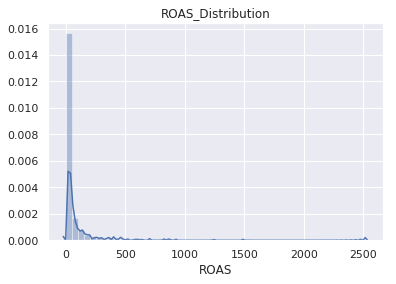

In [14]:
#target distribution
sns.distplot(y).set_title('ROAS_Distribution');

#skewness and kurtosis
print('Skewness: {}'.format(round(y.skew(),2)))
print('Kurtosis: {}'.format(round(y.kurt(),2)))

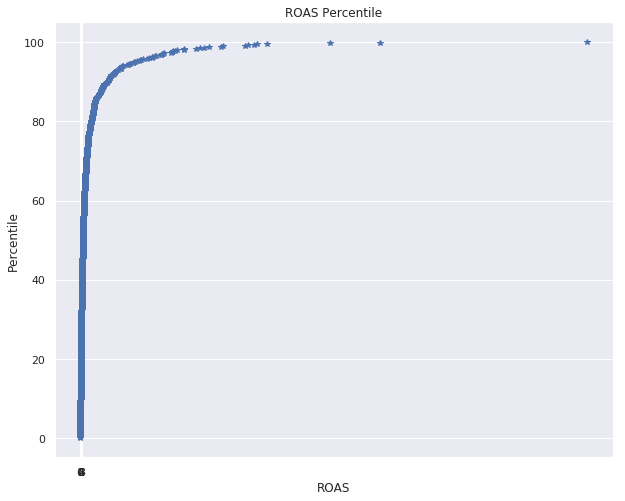

In [15]:
#create percentile
df['percentile'] = df['ROAS'].apply(lambda x: percentileofscore(df['ROAS'], x))

# plot percentile
#set size
plt.figure(figsize = (10, 8))

#establish axis
plt.plot(df['ROAS'], df['percentile'], '*')
plt.xticks(range(0, 10, 2), range(0, 20, 2))

#set labels
plt.xlabel('ROAS')
plt.ylabel('Percentile')
plt.title('ROAS Percentile');

In [16]:
print('Score to achieve 50th percentile: {}'.format(round(np.min(df.loc[df['percentile'] > 50, 'ROAS']),2)))
print('Score to achieve 90th percentile: {}'.format(round(np.min(df.loc[df['percentile'] > 90, 'ROAS']),2)))

Score to achieve 50th percentile: 14.67
Score to achieve 90th percentile: 134.89


**¿How is the target variable distributed?**
<br>As we can see from the previous graphs, the target feature is not normally distributed. 
<br>Moreover, the values of Skewness and Kurtosis are not close to their recommendable value: 0 (these values should be near to 0 in order to achieve a normal distribution).

**¿How can affect to the regression models?**
<br>Most of machine learning models assumes the data is normally distributed and if it is not achieve this goal: the performance of the machine learning models cab be reduced dractically (for example: linear regression).

**¿How can it be solved?**
<br>It is necessary to apply log transformation to these variable.

<a name='distribution_target_log'></a>
## Distribution of logarithm target variable 
Then, it is applied logarithm neperian to the target variable

Skewness: 0.45
Kurtosis: 0.04


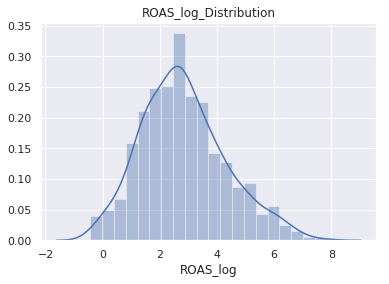

In [17]:
#create log target feature
df['ROAS_log'] = np.log(df['ROAS'])

#drop previous target from dataframe
df.drop('ROAS', axis= 1, inplace=True)

#set as new target
y = df['ROAS_log']

#target distribution
sns.distplot(y).set_title('ROAS_log_Distribution');

#skewness and kurtosis
print('Skewness: {}'.format(round(y.skew(),2)))
print('Kurtosis: {}'.format(round(y.kurt(),2)))

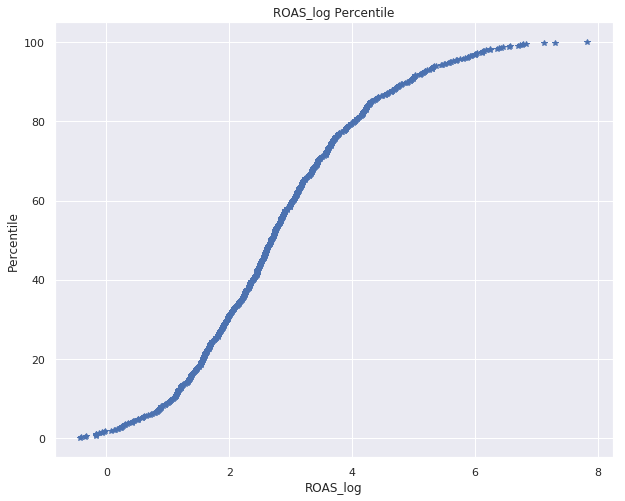

In [18]:
#create percentile
df['percentile'] = df['ROAS_log'].apply(lambda x: percentileofscore(df['ROAS_log'], x))

# plot percentile
#set size
plt.figure(figsize = (10, 8))

#establish axis
plt.plot(df['ROAS_log'], df['percentile'], '*')
plt.xticks(range(0, 10, 2), range(0, 20, 2))

#set labels
plt.xlabel('ROAS_log')
plt.ylabel('Percentile')
plt.title('ROAS_log Percentile');

In [19]:
print('Score to achieve 50th percentile: {}'.format(round(np.min(df.loc[df['percentile'] > 50, 'ROAS_log']),2)))
print('Score to achieve 90th percentile: {}'.format(round(np.min(df.loc[df['percentile'] > 90, 'ROAS_log']),2)))

Score to achieve 50th percentile: 2.69
Score to achieve 90th percentile: 4.9


**¿How is the new target variable distributed?**
<br>As we can observe in the graph, the new target variable is positive skewed (the mean is on the right of the peak) but closer to a normal distribution with mean equal to 0.
<br>In addtion, the values of Skewness and Kurtosis are currently also closer to their recommended scores.



In [20]:
y.describe()

count    782.000000
mean       2.828692
std        1.477199
min       -0.428642
25%        1.772125
50%        2.684627
75%        3.692514
max        7.829630
Name: ROAS_log, dtype: float64

<a name='distribution_target_categorical'></a>
## Target distribution by categorical values

In this chapter, it is studied the distribution of the categorical features with the target variable.

<a name='distribution_target_catprice'></a>
### Target distribution by cat_price
Distribution of cat_price with ROAS_log.
<br> In this case it is necessary to apply this feature as categorical type.

In [21]:
#set as categorical
df['Cat_Price'] = pd.Categorical(df.Cat_Price,categories=["20.0", "30.0", "40.0", "50.0", "60.0", "80.0", 
                                                          "100.0", "150.0","200.0", "300.0"], ordered=True)

Plot the boxplot

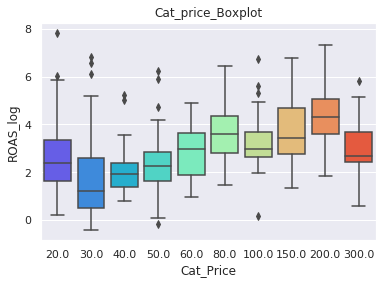

In [22]:
cat_sns1 = sns.boxplot(x='Cat_Price', y='ROAS_log', data=df, palette='rainbow').set_title('Cat_price_Boxplot')

RELLENAR!

Plot the violin plot

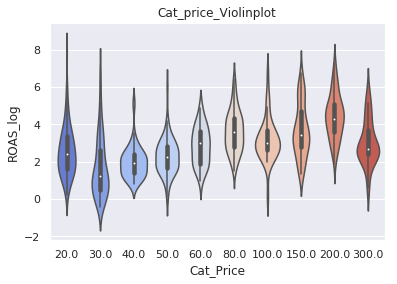

In [23]:
cat_sns2 = sns.violinplot(x='Cat_Price', y='ROAS_log', data=df, palette='coolwarm').set_title('Cat_price_Violinplot')

RELLENAR!

<a name='distribution_target_catn1'></a>
### Target distribution by CatN1
Distribution of category N1 with ROAS_log. 

Plot the boxplot

[Text(0, 0, 'muebles'),
 Text(0, 0, 'decoración para tu casa'),
 Text(0, 0, 'organización y almacenamiento'),
 Text(0, 0, 'baño'),
 Text(0, 0, 'textil hogar'),
 Text(0, 0, 'lámparas e iluminación'),
 Text(0, 0, 'cocina y comedor'),
 Text(0, 0, 'decoración de navidad'),
 Text(0, 0, 'jardín y terraza'),
 Text(0, 0, 'playa y camping')]

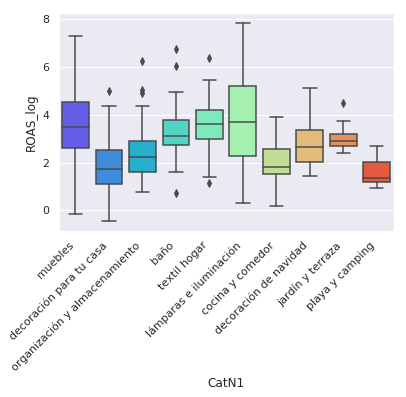

In [26]:
catN1_sns1 = sns.boxplot(x='CatN1', y='ROAS_log', data=df, palette='rainbow')
catN1_sns1.set_xticklabels(catN1_sns1.get_xticklabels(), rotation=45, ha='right')

Plot the violin plot

[Text(0, 0, 'muebles'),
 Text(0, 0, 'decoración para tu casa'),
 Text(0, 0, 'organización y almacenamiento'),
 Text(0, 0, 'baño'),
 Text(0, 0, 'textil hogar'),
 Text(0, 0, 'lámparas e iluminación'),
 Text(0, 0, 'cocina y comedor'),
 Text(0, 0, 'decoración de navidad'),
 Text(0, 0, 'jardín y terraza'),
 Text(0, 0, 'playa y camping')]

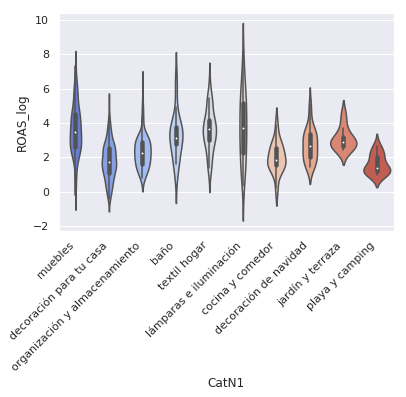

In [27]:
catN1_sns2 = sns.violinplot(x='CatN1', y='ROAS_log', data=df, palette='coolwarm')
catN1_sns2.set_xticklabels(catN1_sns2.get_xticklabels(), rotation=45, ha='right')

<a name='distribution_columns'></a>
## Distribution of numerical features

RELLENAR

KURT AND SWEK = 2 DE limite (establexer arriba)

<a name='skewness_columns'></a>
### Skewness and kurtosis of numerical features

RELLENAR


In [28]:
#select index numerical columns
numerical_columns_index = df.dtypes[(df.dtypes != 'object') & (df.dtypes != 'category')].index

#create a dataframe to save skewness and kurtosis values for numerical columns
data = pd.DataFrame([])

for col in numerical_columns_index:
    data = data.append(pd.DataFrame({'Skewness': round(df[col].skew(),2), 
                                     'Kurtosis': round(df[col].kurt(),2)}, 
                                    index=[0]), ignore_index=True)

Select categorical and object columns in order to create a dataframe

In [29]:
#filter numerical columns
numerical_columns_dist = df.dtypes[(df.dtypes != 'object') & (df.dtypes != 'category')]

#create dataframe with the selection
df_columns_dist = pd.DataFrame({'Index':numerical_columns_dist.index, 'Values':numerical_columns_dist.values})

Concatenate with skewness and kurtosis scores with their index of the previous list 

In [30]:
#concat both dataframes by index
df_concat = pd.concat([df_columns_dist['Index'], data], 1)

#show the values
df_concat

,Index,Skewness,Kurtosis
0,CPC_medio,1.31,3.99
1,CPC_medio_1w,0.08,0.23
2,CPC_medio_2w,-0.18,-0.01
3,CPC_medio_3w,-0.19,-0.10
4,CPC_medio_4w,-0.22,-0.28
5,Impressions,3.30,19.11
6,Impressions_1w,2.05,6.01
7,Impressions_2w,1.85,4.27
8,Impressions_3w,1.77,3.48
9,Impressions_4w,1.74,3.11


Display a couple of examples

Skewness: 15.4
Kurtosis: 290.63


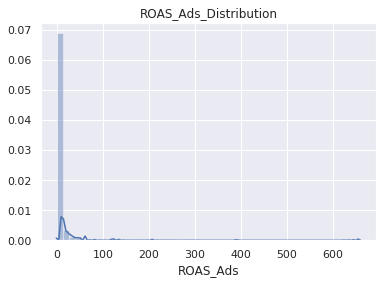

In [31]:
#plot distribution of ROAS_Ads
sns.distplot(df['ROAS_Ads']).set_title('ROAS_Ads_Distribution');

#skewness and kurtosis
print('Skewness: {}'.format(round(df['ROAS_Ads'].skew(),2)))
print('Kurtosis: {}'.format(round(df['ROAS_Ads'].kurt(),2)))

Skewness: 2.12
Kurtosis: 6.09


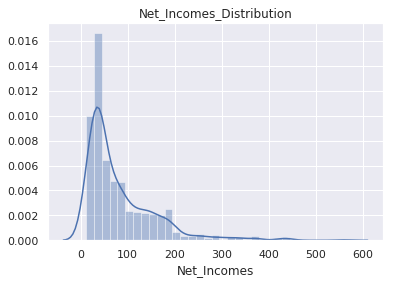

In [32]:
#plot distribution of Net_Incomes
sns.distplot(df['Net_Incomes']).set_title('Net_Incomes_Distribution');

#skewness and kurtosis
print('Skewness: {}'.format(round(df['Net_Incomes'].skew(),2)))
print('Kurtosis: {}'.format(round(df['Net_Incomes'].kurt(),2)))

Apply a filter for selecting features over fixed values of skewness and kurtosis

In [33]:
#filter columns that not accomplish the requirements
df_log = df_concat[(df_concat['Skewness']>=sw) | (df_concat['Kurtosis']>=kurt)]

#show the selection
df_log

,Index,Skewness,Kurtosis
0,CPC_medio,1.31,3.99
5,Impressions,3.30,19.11
6,Impressions_1w,2.05,6.01
7,Impressions_2w,1.85,4.27
8,Impressions_3w,1.77,3.48
9,Impressions_4w,1.74,3.11
10,Clics,2.29,7.31
11,Clics_1w,1.58,2.09
13,Clics_3w,1.59,2.06
14,Clics_4w,1.64,2.28


In [34]:
print('{} features achieve the requirements score of skewness and kurtosis'.format(len(df_concat) - len(df_log)))

14 features achieve the requirements score of skewness and kurtosis


<a name='logarithm_columns'></a>
### Logarithm to numerical features

RELLENAR!

In [35]:
#apply string to index
lista = df_log['Index'].apply(str)

#create a list
c = lista.values.tolist()

#apply log to the list in order to create new columns and drop prevoius features
for col in c:
    df[col+'_log'] = np.log(df[col])
    df.drop([col], axis= 1, inplace=True)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 782 entries, 134 to 207
Data columns (total 66 columns):
CatN1                     782 non-null object
CatN2                     782 non-null object
Cat_Price                 782 non-null category
CPC_medio_1w              782 non-null float64
CPC_medio_2w              782 non-null float64
CPC_medio_3w              782 non-null float64
CPC_medio_4w              782 non-null float64
Clics_2w                  782 non-null float64
CTR_2w                    782 non-null float64
CTR_3w                    782 non-null float64
CTR_4w                    782 non-null float64
Cost_2w                   782 non-null float64
Cost_3w                   782 non-null float64
Cost_4w                   782 non-null float64
Ads_Income_3w             782 non-null float64
percentile                782 non-null float64
ROAS_log                  782 non-null float64
CPC_medio_log             782 non-null float64
Impressions_log           782 non-null float64
I

After applying logarithm to the selected columns, it is shown the new scores of skewness and kurtosis of all columns.

In [37]:
#select index numerical columns
numerical_columns_index_log = df.dtypes[(df.dtypes != 'object') & (df.dtypes != 'category')].index

#create a dataframe to save skewness and kurtosis values for numerical columns
data_log = pd.DataFrame([])

for col in numerical_columns_index_log:
    df[col] = df[col].replace([np.inf, -np.inf], np.nan)
    df[col].fillna(0, inplace = True)
    data_log = data_log.append(pd.DataFrame({'Skewness': round(df[col].skew(),2), 
                                             'Kurtosis': round(df[col].kurt(),2)}, 
                                            index=[0]), ignore_index=True)

#filter numerical columns
numerical_columns_dist_log = df.dtypes[(df.dtypes != 'object') & (df.dtypes != 'category')]

#create dataframe with the selection
df_columns_dist_log = pd.DataFrame({'Index':numerical_columns_dist_log.index, 
                                    'Values':numerical_columns_dist_log.values})    
    
#concat both dataframes by index
df_concat_log = pd.concat([df_columns_dist_log['Index'], data_log], 1)

#show the values
df_concat_log

,Index,Skewness,Kurtosis
0,CPC_medio_1w,0.08,0.23
1,CPC_medio_2w,-0.18,-0.01
2,CPC_medio_3w,-0.19,-0.10
3,CPC_medio_4w,-0.22,-0.28
4,Clics_2w,1.57,1.93
5,CTR_2w,1.04,1.41
6,CTR_3w,1.13,1.50
7,CTR_4w,1.20,1.64
8,Cost_2w,1.49,1.68
9,Cost_3w,1.46,1.52


Display again a couple of examples after that change

Skewness: 1.64
Kurtosis: 2.48


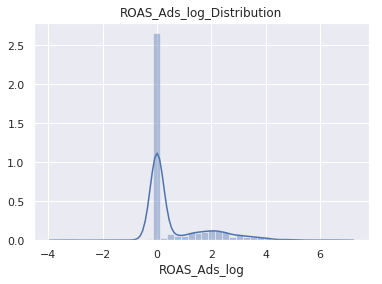

In [38]:
#plot distribution of ROAS_Ads
sns.distplot(df['ROAS_Ads_log']).set_title('ROAS_Ads_log_Distribution');

#skewness and kurtosis
print('Skewness: {}'.format(round(df['ROAS_Ads_log'].skew(),2)))
print('Kurtosis: {}'.format(round(df['ROAS_Ads_log'].kurt(),2)))

Skewness: 0.19
Kurtosis: -0.68


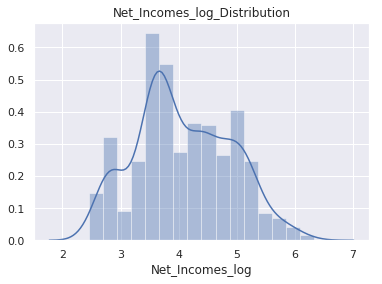

In [39]:
#plot distribution of ROAS_Ads
sns.distplot(df['Net_Incomes_log']).set_title('Net_Incomes_log_Distribution');

#skewness and kurtosis
print('Skewness: {}'.format(round(df['Net_Incomes_log'].skew(),2)))
print('Kurtosis: {}'.format(round(df['Net_Incomes_log'].kurt(),2)))

<a name='relation_numerical_columns'></a>
## Distribution of numerical features with target variable

RELLENAR


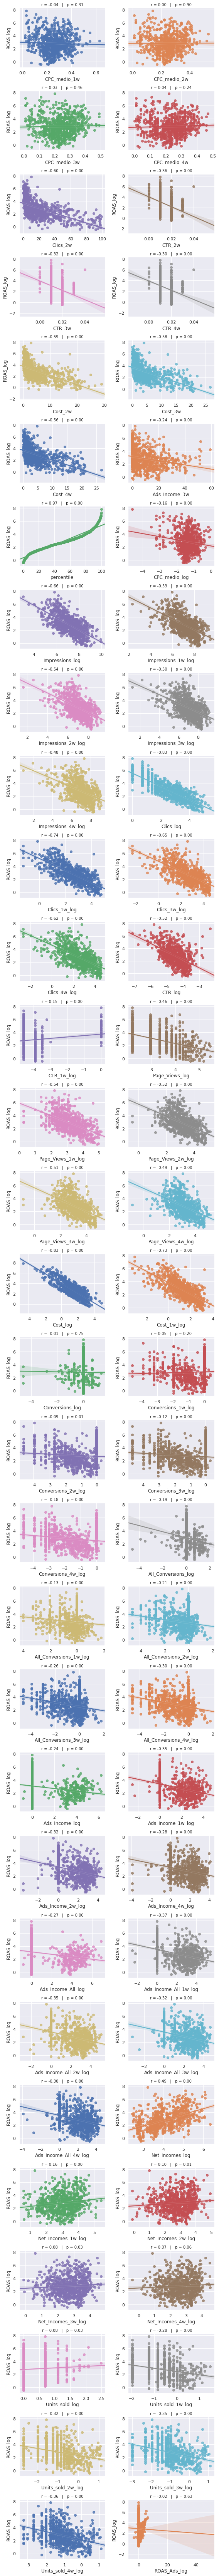

In [40]:
#number of rows and columns
number_rows = 31
number_cols = 2

#set target
y_df = 'ROAS_log'

#create figure
fig, axs = plt.subplots(number_rows, number_cols, figsize=(number_cols*4,number_rows*3))

#establish parameters
li_not_plot = ['ROAS_log', 'percentile_log']
li_plot_num_feats = [c for c in list(numerical_columns_index_log) if c not in li_not_plot]

#loop
for r in range(0,number_rows):
    for c in range(0,number_cols):  
        f = r*number_cols + c
        if f < len(li_plot_num_feats):
            sns.regplot(df[li_plot_num_feats[f]], df[y_df], ax = axs[r][c])
            stp = stats.pearsonr(df[li_plot_num_feats[f]], df[y_df])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "   |   " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=10)
            
plt.tight_layout()    
plt.show()

----------

PODEMOS CONCLUIR SOBRE ESTE GRÁFICO

ADEMAS, DEBEMOS HACER QUE SE VEA , NO TENER QUE DESLIZAR

--------

<a name='relation_categorical_columns'></a>
## Distribution of categorical features with target variable

RELLENAR

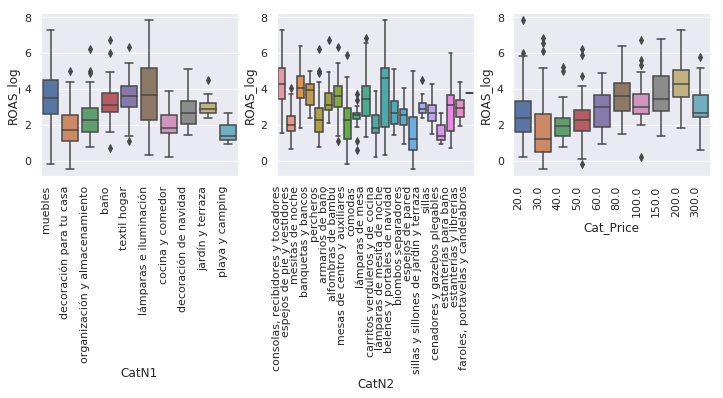

In [42]:
#select categorical columns
categorical_columns_index_log = df.dtypes[(df.dtypes == 'object') | (df.dtypes == 'category')].index

#set number of columns and rows
number_rows = 1
number_cols = 3

#establish target
y_df = 'ROAS_log'

#set parameters
li_cat_columns = list(categorical_columns_index_log)

#create figure
fig, axs = plt.subplots(number_rows, number_cols, figsize=(number_cols*4,number_rows*3), squeeze=False)

#loop
for r in range(0,number_rows):
    for c in range(0,number_cols):  
        f = r*number_cols + c
        if f < len(li_cat_columns):
            g = sns.boxplot(x = li_cat_columns[f], y = y_df, data = df, ax = axs[r][c])
            g.set_xticklabels(g.get_xticklabels(), rotation=90, ha='right')

#show
plt.tight_layout()    
plt.show()

-----------------------------------------------------------------------------------
<a name='data_wrangling'></a>
# Data wrangling

RELLENAR

<a name='data_correlation'></a>
## Correlation

RELLENAR

<a name='data_correlation_numerical_original'></a>
### Correlation of numerical features to target variable

It is measured the correlation of numerical features to target ROAS_log

In [43]:
#drop percentile column
df.drop('percentile', axis=1, inplace=True)

#correlations of numerical features
df.corr()['ROAS_log'].sort_values()

Cost_log                 -0.833547
Clics_log                -0.830358
Clics_1w_log             -0.739110
Cost_1w_log              -0.731156
Impressions_log          -0.662986
Clics_3w_log             -0.648811
Clics_4w_log             -0.624731
Clics_2w                 -0.603167
Cost_2w                  -0.594837
Impressions_1w_log       -0.588960
Cost_3w                  -0.577006
Cost_4w                  -0.558582
Page_Views_1w_log        -0.542899
Impressions_2w_log       -0.541028
CTR_log                  -0.521899
Page_Views_2w_log        -0.517602
Page_Views_3w_log        -0.506331
Impressions_3w_log       -0.504131
Page_Views_4w_log        -0.490880
Impressions_4w_log       -0.480768
Page_Views_log           -0.459876
Ads_Income_All_1w_log    -0.367790
CTR_2w                   -0.360973
Units_sold_4w_log        -0.360664
Ads_Income_All_2w_log    -0.350832
Ads_Income_1w_log        -0.348327
Units_sold_3w_log        -0.348314
Units_sold_2w_log        -0.322501
Ads_Income_2w_log   

<a name='data_correlation_categorical_original'></a>
### Correlation of categorical features to target variable

First of all, it is applied one-hot encoding to the categorical values

In [44]:
#cat price to string
df['Cat_Price'] = df['Cat_Price'].astype(str)

#select categorical columns
df_categorical = df.select_dtypes('object')

#one-hot encoding of these columns
df_categorical = pd.get_dummies(df_categorical, prefix_sep= '_')

#append ROAS_log to dataframe
df_categorical['ROAS_log'] = df['ROAS_log']
df_categorical.head()

,CatN1_baño,CatN1_cocina y comedor,CatN1_decoración de navidad,CatN1_decoración para tu casa,CatN1_jardín y terraza,CatN1_lámparas e iluminación,CatN1_muebles,CatN1_organización y almacenamiento,CatN1_playa y camping,CatN1_textil hogar,CatN2_alfombras de bambú,CatN2_armarios de baño,CatN2_banquetas y bancos,CatN2_belenes y portales de navidad,CatN2_biombos separadores,CatN2_carritos verduleros y de cocina,CatN2_cenadores y gazebos plegables,"CatN2_consolas, recibidores y tocadores",CatN2_cómodas,CatN2_espejos de pared,CatN2_espejos de pie y vestidores,CatN2_estanterías para baño,CatN2_estanterías y librerías,"CatN2_faroles, portavelas y candelabros",CatN2_lámparas de mesa,CatN2_lámparas de mesita de noche,CatN2_mesas de centro y auxiliares,CatN2_mesitas de noche,CatN2_percheros,CatN2_sillas,CatN2_sillas y sillones de jardín y terraza,Cat_Price_100.0,Cat_Price_150.0,Cat_Price_20.0,Cat_Price_200.0,Cat_Price_30.0,Cat_Price_300.0,Cat_Price_40.0,Cat_Price_50.0,Cat_Price_60.0,Cat_Price_80.0,ROAS_log
134,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,7.123903
142,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,4.692163
160,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6.461944
163,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6.244455
168,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,5.097640


It is measured the correlation of categorical features to target ROAS_log

In [45]:
#correlation of categorical features
df_categorical.corr()['ROAS_log'].sort_values()

CatN1_decoración para tu casa                 -0.445117
CatN2_espejos de pared                        -0.402766
Cat_Price_30.0                                -0.307937
Cat_Price_50.0                                -0.181630
Cat_Price_40.0                                -0.177384
CatN2_espejos de pie y vestidores             -0.159787
CatN2_percheros                               -0.121588
CatN1_organización y almacenamiento           -0.121588
CatN2_cenadores y gazebos plegables           -0.107679
CatN1_playa y camping                         -0.107679
CatN2_mesas de centro y auxiliares            -0.103262
CatN2_carritos verduleros y de cocina         -0.077760
CatN1_cocina y comedor                        -0.077760
Cat_Price_20.0                                -0.067824
CatN2_cómodas                                 -0.043074
CatN2_biombos separadores                     -0.031263
CatN2_sillas                                  -0.020321
CatN2_belenes y portales de navidad           -0

<a name='data_feature_selection'></a>
## Feature Selection

RELLENAR


**Why should it be applied feature selection to this dataset?**
    * It enables the machine learning algorithm to train faster.
    * It reduces the complexity of a model and makes it easier to interpret.
    * It improves the accuracy of a model if the right subset is chosen.
    * It reduces overfitting.
    
    #meter fuente
    https://datascientistssite.wordpress.com/2017/08/21/univariate-selection-feature-in-python/

First of all, it is necessary to make one-hot encoding for categorical features, but in this case, applying and saving the values at the same dataframe as numerical columns.

In [46]:
#one-hot encoding of these columns
df_all = pd.get_dummies(df, prefix_sep = '_')

#columns to list
columns = df_all.columns.tolist()

#set X and y
X = df_all[['CPC_medio_1w', 'CPC_medio_2w', 'CPC_medio_3w', 'CPC_medio_4w', 'Clics_2w', 'CTR_2w', 'CTR_3w', 
            'CTR_4w', 'Cost_2w', 'Cost_3w', 'Cost_4w', 'Ads_Income_3w', 'CPC_medio_log', 'Impressions_log', 
            'Impressions_1w_log', 'Impressions_2w_log', 'Impressions_3w_log', 'Impressions_4w_log', 'Clics_log', 
            'Clics_1w_log', 'Clics_3w_log', 'Clics_4w_log', 'CTR_log', 'CTR_1w_log', 'Page_Views_log', 
            'Page_Views_1w_log', 'Page_Views_2w_log', 'Page_Views_3w_log', 'Page_Views_4w_log', 'Cost_log', 
            'Cost_1w_log', 'Conversions_log', 'Conversions_1w_log', 'Conversions_2w_log', 'Conversions_3w_log', 
            'Conversions_4w_log', 'All_Conversions_log', 'All_Conversions_1w_log', 'All_Conversions_2w_log', 
            'All_Conversions_3w_log', 'All_Conversions_4w_log', 'Ads_Income_log', 'Ads_Income_1w_log', 
            'Ads_Income_2w_log', 'Ads_Income_4w_log', 'Ads_Income_All_log', 'Ads_Income_All_1w_log', 
            'Ads_Income_All_2w_log', 'Ads_Income_All_3w_log', 'Ads_Income_All_4w_log', 'Net_Incomes_log', 
            'Net_Incomes_1w_log', 'Net_Incomes_2w_log', 'Net_Incomes_3w_log', 'Net_Incomes_4w_log', 
            'Units_sold_log', 'Units_sold_1w_log', 'Units_sold_2w_log', 'Units_sold_3w_log', 'Units_sold_4w_log', 
            'ROAS_Ads_log', 'CatN1_baño', 'CatN1_cocina y comedor', 'CatN1_decoración de navidad', 
            'CatN1_decoración para tu casa', 'CatN1_jardín y terraza', 'CatN1_lámparas e iluminación', 
            'CatN1_muebles', 'CatN1_organización y almacenamiento', 'CatN1_playa y camping', 'CatN1_textil hogar', 
            'CatN2_alfombras de bambú', 'CatN2_armarios de baño', 'CatN2_banquetas y bancos', 
            'CatN2_belenes y portales de navidad', 'CatN2_biombos separadores', 
            'CatN2_carritos verduleros y de cocina', 'CatN2_cenadores y gazebos plegables', 
            'CatN2_consolas, recibidores y tocadores', 'CatN2_cómodas', 'CatN2_espejos de pared', 
            'CatN2_espejos de pie y vestidores', 'CatN2_estanterías para baño', 'CatN2_estanterías y librerías', 
            'CatN2_faroles, portavelas y candelabros', 'CatN2_lámparas de mesa', 
            'CatN2_lámparas de mesita de noche', 'CatN2_mesas de centro y auxiliares', 'CatN2_mesitas de noche', 
            'CatN2_percheros', 'CatN2_sillas', 'CatN2_sillas y sillones de jardín y terraza', 'Cat_Price_100.0', 
            'Cat_Price_150.0', 'Cat_Price_20.0', 'Cat_Price_200.0', 'Cat_Price_30.0', 'Cat_Price_300.0', 
            'Cat_Price_40.0', 'Cat_Price_50.0', 'Cat_Price_60.0', 'Cat_Price_80.0']]

y = df_all.ROAS_log

#X columns to list
feature_name = X.columns.tolist()

<a name='data_pearson'></a>
### Pearson

RELLENAR


In [47]:
#apply pearson function
corr_support, corr_feature = pearson_selector(feature_name, X, y)

#print result
print('The number of selected features is {}'.format(str(len(corr_feature))))

The number of selected features is 20


EXPLICAR

<a name='data_random_forest'></a>
### Random Forest

RELLENAR

In [52]:
#apply random forest
embeded_rf_selector = SelectFromModel(RandomForestRegressor(n_estimators=15), threshold='3*median')

#fit
embeded_rf_selector.fit(X, y)

SelectFromModel(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
        max_features=None, norm_order=1, prefit=False,
        threshold='3*median')

In [53]:
#support
embeded_rf_support = embeded_rf_selector.get_support()

#list
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
#print(str(len(embeded_rf_feature)), 'selected features')

#print result
print('The number of selected features is {}'.format(str(len(embeded_rf_feature))))

The number of selected features is 20


EXPLICAR

<a name='data_LGBMRegressor'></a>
### LGBMRegressor

RELLENAR

In [54]:
#apply LGBMRegressor
lgbc= LGBMRegressor(n_estimators=30, learning_rate=0.05, num_leaves=25, colsample_bytree=0.3,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=5)

#set parameters to selector
embeded_lgb_selector = SelectFromModel(lgbc, threshold='5*median')

#fit
embeded_lgb_selector.fit(X, y)

SelectFromModel(estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.3,
       importance_type='split', learning_rate=0.05, max_depth=-1,
       min_child_samples=20, min_child_weight=5, min_split_gain=0.01,
       n_estimators=30, n_jobs=-1, num_leaves=25, objective=None,
       random_state=None, reg_alpha=3, reg_lambda=1, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
        max_features=None, norm_order=1, prefit=False,
        threshold='5*median')

In [55]:
#support
embeded_lgb_support = embeded_lgb_selector.get_support()

#list
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()

#print(str(len(embeded_lgb_feature)), 'selected features')
#print result
print('The number of selected features is {}'.format(str(len(embeded_lgb_feature))))

The number of selected features is 15


EXPLICAR

<a name='data_final_feature_selection'></a>
### Final Feature Selection

RELLENAR



In [56]:
#all selection in a dataframe
feature_selection = pd.DataFrame({'Feature':feature_name, 
                                  'Pearson':corr_support, 
                                  'Random Forest':embeded_rf_support, 
                                  'LightGBM':embeded_lgb_support})

#count
feature_selection['Total'] = np.sum(feature_selection, axis=1)

#print
feature_selection = feature_selection.sort_values(['Total','Feature'] , ascending=False)
feature_selection.index = range(1, len(feature_selection)+1)
feature_selection.head(50)

,Feature,Pearson,Random Forest,LightGBM,Total
1,Net_Incomes_log,True,True,True,3
2,Cost_log,True,True,True,3
3,Cost_3w,True,True,True,3
4,Cost_1w_log,True,True,True,3
5,Clics_log,True,True,True,3
6,Clics_2w,True,True,True,3
7,CTR_log,True,True,True,3
8,Net_Incomes_4w_log,False,True,True,2
9,Net_Incomes_3w_log,False,True,True,2
10,Net_Incomes_2w_log,False,True,True,2


We select Top 29 columns: del 10 al 29 tienen 1

In [58]:
#filter of Total = 2 
columns_select_final = feature_selection [feature_selection['Total'] >= 2]

#select features
columns_selection = columns_select_final['Feature']

#apply to dataframe
df_final = df_all[columns_selection]

#head
df_final.head()

,Net_Incomes_log,Cost_log,Cost_3w,Cost_1w_log,Clics_log,Clics_2w,CTR_log,Net_Incomes_4w_log,Net_Incomes_3w_log,Net_Incomes_2w_log,Net_Incomes_1w_log,Impressions_log,Impressions_1w_log,Cost_2w,Clics_1w_log,CPC_medio_log
134,6.074081,-1.049822,0.02,-2.995732,0.693147,0.14,-2.351375,4.238156,4.437698,4.746583,4.645736,3.044522,3.306520,0.02,-1.237874,-1.714798
142,4.992268,0.300105,0.16,-0.867501,1.386294,1.00,-3.258097,4.229749,4.428433,3.952589,3.046425,4.644391,4.577696,0.24,0.536493,-1.078810
160,4.992268,-1.469676,0.49,-0.415515,0.693147,1.64,-5.303305,3.259634,2.641198,2.353278,3.046425,5.996452,5.418631,0.44,0.620576,-2.120264
163,4.935121,-1.309333,0.52,-0.301105,0.000000,1.71,-5.966147,2.740195,2.613007,3.017983,3.711375,5.966147,5.676274,0.53,0.828552,-1.309333
168,5.628268,0.530628,0.55,-0.385662,0.693147,1.71,-4.770685,3.414114,3.511844,3.917210,4.375505,5.463832,5.390395,0.65,0.357674,-0.162519


Check the data

In [59]:
df_final.shape

(782, 16)

In [60]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 782 entries, 134 to 207
Data columns (total 16 columns):
Net_Incomes_log       782 non-null float64
Cost_log              782 non-null float64
Cost_3w               782 non-null float64
Cost_1w_log           782 non-null float64
Clics_log             782 non-null float64
Clics_2w              782 non-null float64
CTR_log               782 non-null float64
Net_Incomes_4w_log    782 non-null float64
Net_Incomes_3w_log    782 non-null float64
Net_Incomes_2w_log    782 non-null float64
Net_Incomes_1w_log    782 non-null float64
Impressions_log       782 non-null float64
Impressions_1w_log    782 non-null float64
Cost_2w               782 non-null float64
Clics_1w_log          782 non-null float64
CPC_medio_log         782 non-null float64
dtypes: float64(16)
memory usage: 123.9 KB


<a name='outliers'></a>
## Outliers

#RELLENAR

Outliers exists in our dataset because of variability of the data.

In [68]:
#introduce log
df_final['ROAS_log'] = df['ROAS_log']
df_final['ROAS_log'] = y

#index dtypes 
numerical_columns_selection = df_final.dtypes.index

#create empty dataframe
data_IQR = pd.DataFrame([])

#calculate IQR for each feature
for col in numerical_columns_selection:
    Q1 = df_final[col].quantile(0.25)
    Q3 = df_final[col].quantile(0.75)
    data_IQR = data_IQR.append(pd.DataFrame({'IQR': round(Q3 - Q1,2)}, index=[0]), ignore_index=True)

RELLENAR!

In [69]:
#dictionary dtypes
numerical_columns_selection_final = df_final.dtypes

#dataframe
numerical_columns_selection_final = pd.DataFrame({'Index':numerical_columns_selection_final.index, 
                                    'Values':numerical_columns_selection_final.values})   

RELLENAR!

In [70]:
#concat dataframes
df_concat_IQR = pd.concat([numerical_columns_selection_final['Index'], data_IQR], 1)
df_concat_IQR

,Index,IQR
0,Net_Incomes_log,1.16
1,Cost_log,1.63
2,Cost_3w,5.50
3,Cost_1w_log,1.60
4,Clics_log,1.76
5,Clics_2w,23.58
6,CTR_log,0.78
7,Net_Incomes_4w_log,1.25
8,Net_Incomes_3w_log,1.25
9,Net_Incomes_2w_log,1.23


Apply IQR to the dataset

In [74]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = round(Q3 - Q1,2)

df_final = df_final[~((df_final < (Q1 - 1.5 * IQR)) | (df_final > (Q3 + 1.5 * IQR))).any(axis=1)]

In [75]:
df_final.shape

(631, 17)

<a name='correlation_feature_selection'></a>
## Correlation feature selection

#RELLENAR

In [76]:
df_final.corr()['ROAS_log'].sort_values()

Clics_log            -0.791801
Cost_log             -0.784966
Clics_1w_log         -0.715019
Cost_1w_log          -0.686529
Impressions_log      -0.587580
Clics_2w             -0.580055
Cost_2w              -0.559103
CTR_log              -0.548987
Impressions_1w_log   -0.519896
Cost_3w              -0.510695
CPC_medio_log        -0.039019
Net_Incomes_3w_log    0.190986
Net_Incomes_4w_log    0.191513
Net_Incomes_2w_log    0.213090
Net_Incomes_1w_log    0.266921
Net_Incomes_log       0.554878
ROAS_log              1.000000
Name: ROAS_log, dtype: float64

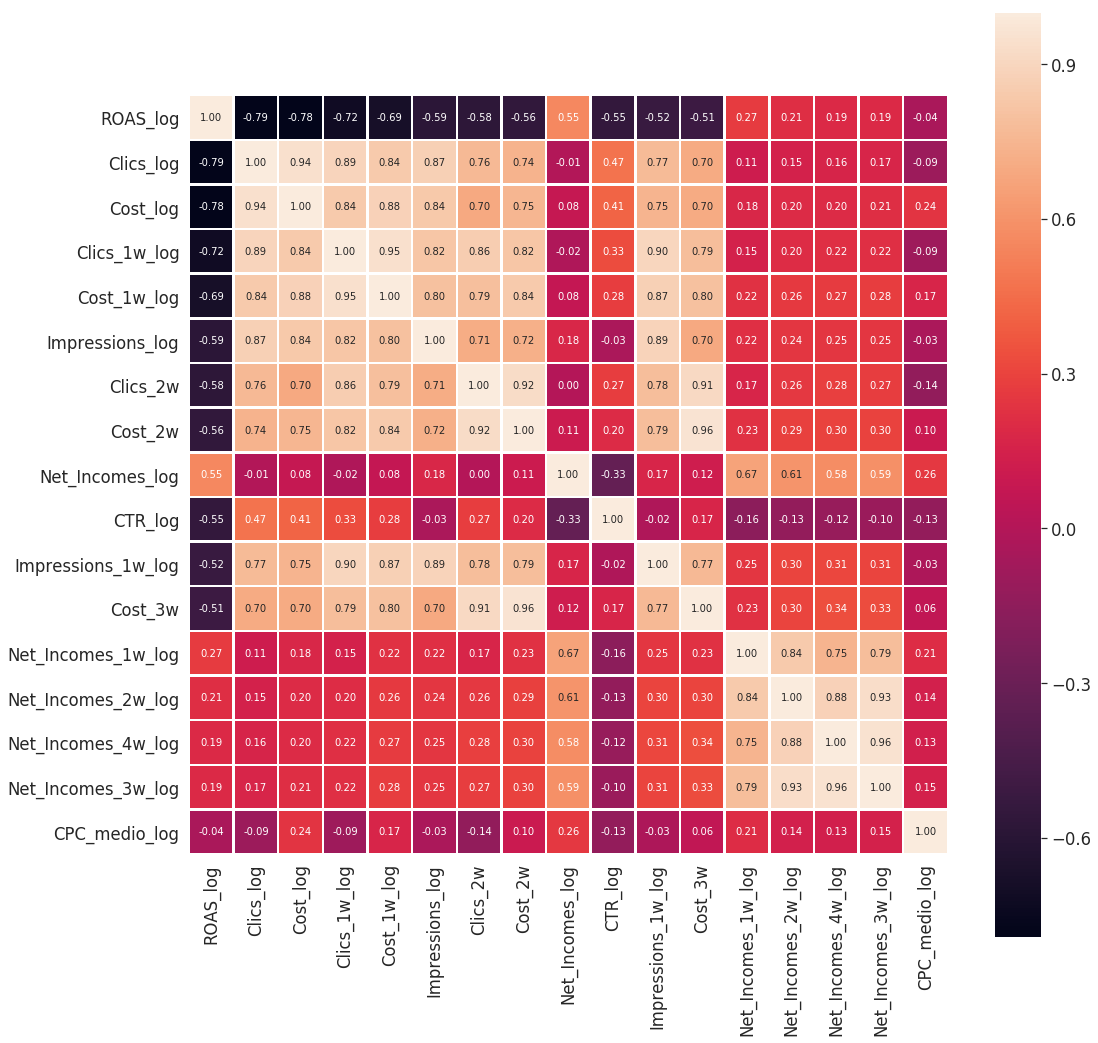

In [80]:
#length columns
number_columns = len(df_final.columns)

#heatmap
plot_correlation_heatmap(df_final, number_columns, "ROAS_log")

<a name='distribution_feature_selection'></a>
## Distribution of feature selection with target

#RELLENAR

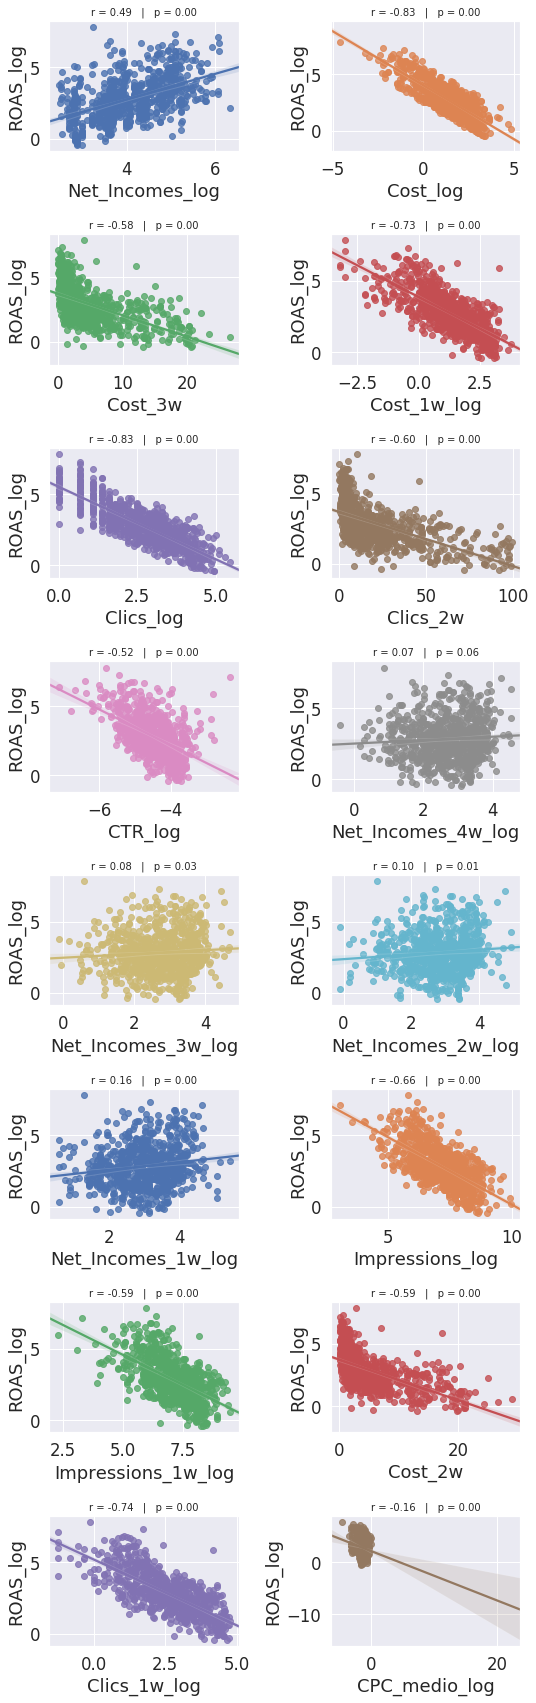

In [87]:
#select index numerical columns
columns_dtypes = df_final.dtypes.index

#number of rows and columns
number_rows = int((number_columns/2))
number_cols = 2

#set target
y_df = 'ROAS_log'

#create figure
fig, axs = plt.subplots(number_rows, number_cols, figsize=(number_cols*4,number_rows*3))

#establish parameters
li_not_plot = ['ROAS_log']
li_plot_num_feats = [c for c in list(columns_dtypes) if c not in li_not_plot]

#loop
for r in range(0,number_rows):
    for c in range(0,number_cols):  
        f = r*number_cols + c
        if f < len(li_plot_num_feats):
            sns.regplot(df[li_plot_num_feats[f]], df[y_df], ax = axs[r][c])
            stp = stats.pearsonr(df[li_plot_num_feats[f]], df[y_df])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "   |   " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=10)
            
plt.tight_layout()    
plt.show()

<a name='multicollinearity'></a>
## Multicollinearity

RELLENAR

In [159]:
#save correlation
corr_final = df_final.corr()['ROAS_log'].sort_values()

#correlation to dataframe
df_corr_final = pd.DataFrame({'Index':corr_final.index, 'Values':abs(corr_final.values)}) 
df_corr_final

#split the index
df_corr_final[['First', 'Second', 'Third', 'Fourht']] = df_corr_final['Index'].str.rsplit("_", n = 3, expand=True)

#sort values
df_corr_final = df_corr_final.sort_values(by = 'Values', ascending = False)

#groupby
df_groupby = df_corr_final.groupby('First').first()

#select column
columns_groupby = ['First', 'Index', 'Values']

#display
df_groupby.reset_index(inplace = True)
df_groupby = df_groupby[columns_groupby]
df_groupby

,First,Index,Values
0,CPC,CPC_medio_log,0.039019
1,CTR,CTR_log,0.548987
2,Clics,Clics_log,0.791801
3,Cost,Cost_log,0.784966
4,Impressions,Impressions_log,0.587580
5,Net,Net_Incomes_log,0.554878
6,ROAS,ROAS_log,1.000000
7,percentile,percentile,0.975977


In [169]:
#save features selected as columns
df_columns_list = df_groupby.Index.values.tolist()

#select columns
df_columns_list

#save data
df_all = df_final[df_columns_list]

Check dataset

In [170]:
df_all.head()

,CPC_medio_log,CTR_log,Clics_log,Cost_log,Impressions_log,Net_Incomes_log,ROAS_log,percentile
142,-1.078810,-3.258097,1.386294,0.300105,4.644391,4.992268,4.692163,90.332805
160,-2.120264,-5.303305,0.693147,-1.469676,5.996452,4.992268,6.461944,99.841521
163,-1.309333,-5.966147,0.000000,-1.309333,5.966147,4.935121,6.244455,99.683043
174,-0.967584,-5.027165,0.693147,-0.287682,5.720312,4.883786,5.171468,95.087163
175,-0.967584,-4.682131,1.098612,0.122218,5.780744,5.097669,4.975451,93.185420


In [171]:
df_all.shape

(631, 8)

In [172]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 631 entries, 142 to 207
Data columns (total 8 columns):
CPC_medio_log      631 non-null float64
CTR_log            631 non-null float64
Clics_log          631 non-null float64
Cost_log           631 non-null float64
Impressions_log    631 non-null float64
Net_Incomes_log    631 non-null float64
ROAS_log           631 non-null float64
percentile         631 non-null float64
dtypes: float64(8)
memory usage: 44.4 KB


<a name='standardscaler'></a>
## StandardScaler

#EXPLICAR POR QUE ESCALAR

In [173]:
#apply standardscaler
sc = StandardScaler()
df_all_sc = sc.fit_transform(df_all)

#final dataset
df_all_sc = pd.DataFrame(df_all_sc)

#rename columns
df_all_sc.columns = df_columns_list

Check the data

In [174]:
df_all_sc.head(5)

,CPC_medio_log,CTR_log,Clics_log,Cost_log,Impressions_log,Net_Incomes_log,ROAS_log,percentile
0,0.707975,2.486583,-1.154925,-0.900961,-2.702195,1.128483,1.453319,1.394426
1,-2.287737,-1.502807,-1.825774,-2.572674,-1.221886,1.128483,2.848525,1.723818
2,0.044880,-2.795749,-2.496624,-2.421216,-1.255066,1.055998,2.677067,1.718328
3,1.027912,-0.964167,-1.825774,-1.456177,-1.524219,0.990884,1.831179,1.559122
4,1.027912,-0.291144,-1.433352,-1.068991,-1.458055,1.262175,1.676649,1.493244


In [175]:
df_all_sc.shape

(631, 8)

In [176]:
df_all_sc.describe()

,CPC_medio_log,CTR_log,Clics_log,Cost_log,Impressions_log,Net_Incomes_log,ROAS_log,percentile
count,6.310000e+02,6.310000e+02,6.310000e+02,6.310000e+02,6.310000e+02,6.310000e+02,6.310000e+02,6.310000e+02
mean,1.379421e-16,-6.531138e-16,-4.504233e-17,2.702540e-16,-1.351270e-16,-8.445437e-16,2.252116e-16,4.504233e-17
std,1.000793e+00,1.000793e+00,1.000793e+00,1.000793e+00,1.000793e+00,1.000793e+00,1.000793e+00,1.000793e+00
min,-2.812179e+00,-2.845134e+00,-2.496624e+00,-2.858204e+00,-2.745136e+00,-2.085087e+00,-2.525821e+00,-1.729308e+00
25%,-6.780184e-01,-6.723869e-01,-7.625030e-01,-6.558460e-01,-7.431249e-01,-6.457727e-01,-7.428330e-01,-8.646540e-01
50%,-6.367884e-02,7.535989e-02,1.243118e-01,5.139800e-02,8.313602e-02,-1.623130e-01,-1.004746e-01,0.000000e+00
75%,6.650390e-01,7.156841e-01,7.453691e-01,6.977652e-01,7.556000e-01,8.157878e-01,6.346256e-01,8.646540e-01
max,2.743785e+00,2.654360e+00,2.445070e+00,2.634578e+00,2.290261e+00,2.523413e+00,2.928671e+00,1.729308e+00


<a name='grade_percentile_target'></a>
## Grade Percentile of target variable

#RELLENAR

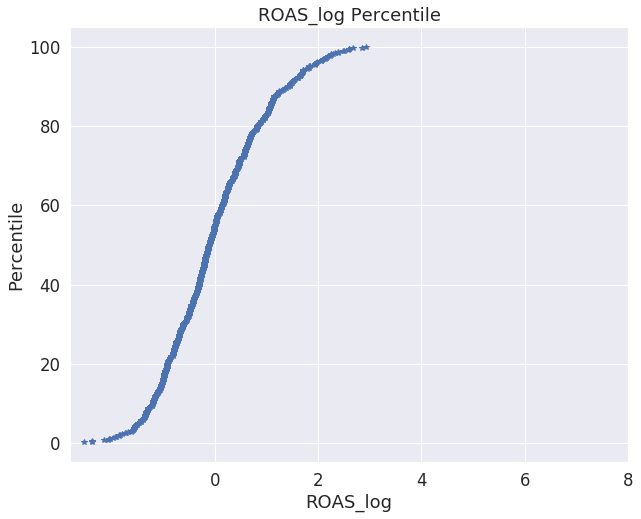

In [177]:
#create percentile
df_all_sc['percentile'] = df_all_sc['ROAS_log'].apply(lambda x: percentileofscore(df_all_sc['ROAS_log'], x))

# plot percentile
#set size
plt.figure(figsize = (10, 8))

#establish axis
plt.plot(df_all_sc['ROAS_log'], df_all_sc['percentile'], '*')
plt.xticks(range(0, 10, 2), range(0, 20, 2))

#set labels
plt.xlabel('ROAS_log')
plt.ylabel('Percentile')
plt.title('ROAS_log Percentile');

In [178]:
print('Score 50th percentile: {}'.format(round(np.min(df_final.loc[df_all_sc['percentile'] > 50, 'ROAS_log']),2)))
print('Score 90th percentile: {}'.format(round(np.min(df_final.loc[df_all_sc['percentile'] > 90, 'ROAS_log']),2)))

Score 50th percentile: -0.36
Score 90th percentile: 0.84


<a name='distribution_final_dataset'></a>
## Correlation and Distribution final dataset

RELLENAR

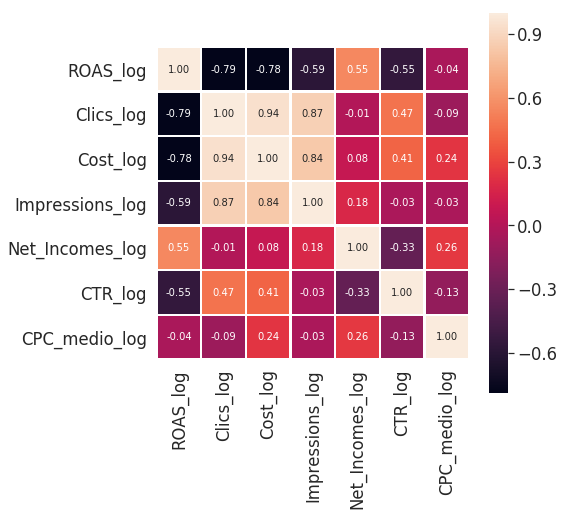

In [180]:
#remove percentile feature
df_all_sc.drop('percentile', axis=1, inplace=True)

#length columns
number_columns = len(df_all_sc.columns)

#heatmap
plot_correlation_heatmap(df_all_sc, number_columns, "ROAS_log")

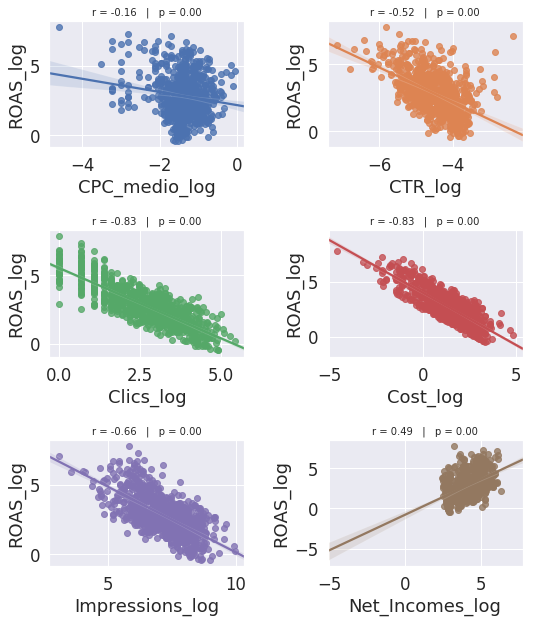

In [183]:
#select index numerical columns
columns_dtypes = df_all_sc.dtypes.index

#number of rows and columns
number_rows = int((number_columns/2))
number_cols = 2

#set target
y_df = 'ROAS_log'

#create figure
fig, axs = plt.subplots(number_rows, number_cols, figsize=(number_cols*4,number_rows*3))

#establish parameters
li_not_plot = ['ROAS_log']
li_plot_num_feats = [c for c in list(columns_dtypes) if c not in li_not_plot]

#loop
for r in range(0,number_rows):
    for c in range(0,number_cols):  
        f = r*number_cols + c
        if f < len(li_plot_num_feats):
            sns.regplot(df[li_plot_num_feats[f]], df[y_df], ax = axs[r][c])
            stp = stats.pearsonr(df[li_plot_num_feats[f]], df[y_df])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "   |   " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=10)
            
plt.tight_layout()    
plt.show()

<a name='regression_models'></a>
# Regression Models

In [109]:
df_final_sc.columns

Index(['Page_Views', 'Net_Incomes_log', 'Net_Incomes', 'Clics', 'Cat_Price',
       'CatN2_espejos_de_pared', 'CatN1_decoración_para_tu_casa',
       'Units_Sold_log', 'ROAS_log'],
      dtype='object')

In [110]:
X = df_final_sc[['Page_Views', 'Net_Incomes_log', 'Net_Incomes', 'Clics', 'Cat_Price',
       'CatN2_espejos_de_pared', 'CatN1_decoración_para_tu_casa', 'Units_Sold_log']]

In [111]:
y = df_final_sc["ROAS_log"]

We test the following Regressors from scikit-learn:
    - LinearRegression
    - KNN Regressor
    - Ridge
    - Lasso
    - Elastic Net
    - Gradient Boosting Descent
    - Decision Tree Regressor
    - Random Forest Regressor
    - SVR

In [112]:
from sklearn.model_selection import GridSearchCV, cross_validate

In [113]:
score_calc = 'neg_mean_squared_error'
scoring = {'abs_error': 'neg_mean_absolute_error', 'squared_error': 'neg_mean_squared_error', 'rsquared':'r2'}

# mirar si hacemos predict

### KNN

In [114]:
from sklearn.neighbors import KNeighborsRegressor

In [123]:
import math

In [115]:
reg_knn_gs = GridSearchCV(KNeighborsRegressor(),
                  param_grid={"n_neighbors":np.arange(4,100)},
                  cv=5,
                  scoring=score_calc)

In [116]:
reg_knn_gs.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': array([ 4,  5, ..., 98, 99])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [117]:
knn_best_params = reg_knn_gs.best_params_.get('n_neighbors')

In [118]:
knn_best_params

6

In [119]:
reg_knn = KNeighborsRegressor(n_neighbors= knn_best_params)

In [120]:
scores = cross_validate(reg_knn, X, y, cv=5, scoring=scoring, return_train_score=True)

In [121]:
knn_mae = abs(scores['test_abs_error'].mean())

In [124]:
knn_rmse = math.sqrt(abs(scores['test_squared_error'].mean()))

In [125]:
knn_r2 = abs(scores['test_rsquared'].mean())

### Linear Regression

In [126]:
from sklearn.linear_model import LinearRegression

In [127]:
linreg = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_linear = GridSearchCV(linreg, parameters, cv=5, verbose=1 , scoring = score_calc)
grid_linear.fit(X, y)

sc_linear = get_best_score(grid_linear)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.6556382207916831
{'copy_X': True, 'fit_intercept': False, 'normalize': True}
LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=True)


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.5s finished


In [128]:
mlr_best_params = grid_linear.best_params_
mlr_best_params

{'copy_X': True, 'fit_intercept': False, 'normalize': True}

In [129]:
reg_mlr = LinearRegression(mlr_best_params)

In [130]:
scores_mlr = cross_validate(reg_mlr, X, y, cv=5, scoring=scoring, return_train_score=True)

In [131]:
mlr_mae = abs(scores_mlr['test_abs_error'].mean())

In [132]:
mlr_rmse = math.sqrt(abs(scores_mlr['test_squared_error'].mean()))

In [133]:
mlr_r2 = abs(scores_mlr['test_rsquared'].mean())

### Decision Tree Regressor

In [134]:
from sklearn.tree import DecisionTreeRegressor

In [135]:
reg_dtr = GridSearchCV(DecisionTreeRegressor(),
                  param_grid={"max_depth":np.arange(2,8),
                              "min_samples_leaf":[10,30,50,100]},
                  cv=5,
                  scoring="neg_mean_absolute_error")

In [136]:
reg_dtr.fit(X,y)

/home/miguel/my_project_python/my_project_env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': array([2, 3, 4, 5, 6, 7]), 'min_samples_leaf': [10, 30, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [137]:
dtr_best_params = reg_dtr.best_params_
dtr_best_params

{'max_depth': 7, 'min_samples_leaf': 10}

In [138]:
reg_dtr = DecisionTreeRegressor(max_depth= 7, min_samples_leaf= 10)

In [139]:
scores_dtr = cross_validate(reg_dtr, X, y, cv=5, scoring=scoring, return_train_score=True)

In [140]:
dtr_mae = abs(scores_dtr['test_abs_error'].mean())

In [141]:
dtr_rmse = math.sqrt(abs(scores_dtr['test_squared_error'].mean()))

In [142]:
dtr_r2 = abs(scores_dtr['test_rsquared'].mean())

### Gradient Boosting Regressor

In [143]:
from sklearn.ensemble import GradientBoostingRegressor

In [144]:
reg_gbr = GridSearchCV(GradientBoostingRegressor(n_estimators=20),
                  param_grid={"max_depth":np.arange(2,10),
                             "learning_rate":np.arange(1,10)/10},
                  scoring="neg_mean_absolute_error",
                  cv=5)

In [145]:
reg_gbr.fit(X,y)

/home/miguel/my_project_python/my_project_env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]), 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [146]:
reg_gbr.best_params_

{'learning_rate': 0.4, 'max_depth': 2}

In [147]:
gbr_best_params = GradientBoostingRegressor(max_depth=8, n_estimators=20,learning_rate=0.3)

In [148]:
scores_gbr = cross_validate(gbr_best_params, X, y, cv=5, scoring=scoring, return_train_score=True)

In [149]:
gbr_mae = abs(scores_gbr['test_abs_error'].mean())

In [150]:
gbr_rmse = math.sqrt(abs(scores_gbr['test_squared_error'].mean()))

In [151]:
gbr_r2 = abs(scores_gbr['test_rsquared'].mean())

### Ridge

In [152]:
from sklearn.linear_model import Ridge

In [158]:
ridge = Ridge()
parameters = {'alpha':[0.001,0.005,0.01,0.1,0.5,1], 'normalize':[True,False], 'tol':[1e-06,5e-06,1e-05,5e-05]}
grid_ridge = GridSearchCV(ridge, parameters, cv=5, verbose=1, scoring = score_calc)
grid_ridge.fit(X, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    1.9s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.001, 0.005, 0.01, 0.1, 0.5, 1], 'normalize': [True, False], 'tol': [1e-06, 5e-06, 1e-05, 5e-05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [159]:
ridge_params = grid_ridge.best_params_

In [160]:
ridge_best_params = Ridge(alpha= 0.1, normalize= True, tol= 1e-06)

In [161]:
scores_ridge = cross_validate(ridge_best_params, X, y, cv=5, scoring=scoring, return_train_score=True)

In [162]:
ridge_mae = abs(scores_ridge['test_abs_error'].mean())

In [163]:
ridge_rmse = math.sqrt(abs(scores_ridge['test_squared_error'].mean()))

In [164]:
ridge_r2 = abs(scores_ridge['test_rsquared'].mean())

### Lasso

In [165]:
from sklearn.linear_model import Lasso

In [166]:
lasso = Lasso()
parameters = {'alpha':[1e-03,0.01,0.1,0.5,0.8,1], 'normalize':[True,False], 'tol':[1e-06,1e-05,5e-05,1e-04,5e-04,1e-03]}
grid_lasso = GridSearchCV(lasso, parameters, cv=5, verbose=1, scoring = score_calc)
grid_lasso.fit(X, y)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    3.4s finished
/home/miguel/my_project_python/my_project_env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.001, 0.01, 0.1, 0.5, 0.8, 1], 'normalize': [True, False], 'tol': [1e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [167]:
grid_lasso.best_params_

{'alpha': 0.1, 'normalize': False, 'tol': 0.001}

In [168]:
reg_lasso = Lasso(alpha= 0.001, normalize= True, tol= 0.0005)

In [169]:
scores_lasso = cross_validate(reg_lasso, X, y, cv=5, scoring=scoring, return_train_score=True)

In [170]:
lasso_mae = abs(scores_lasso['test_abs_error'].mean())

In [171]:
lasso_rmse = math.sqrt(abs(scores_lasso['test_squared_error'].mean()))

In [172]:
lasso_r2 = abs(scores_lasso['test_rsquared'].mean())

### Elastic Net

In [173]:
from sklearn.linear_model import ElasticNet

In [174]:
enet = ElasticNet()
parameters = {'alpha' :[0.1,1.0,10], 'max_iter' :[1000000], 'l1_ratio':[0.04,0.05], 
              'fit_intercept' : [False,True], 'normalize':[True,False], 'tol':[1e-02,1e-03,1e-04]}
grid_enet = GridSearchCV(enet, parameters, cv=5, verbose=1, scoring = score_calc)
grid_enet.fit(X, y)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    3.3s finished
/home/miguel/my_project_python/my_project_env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.1, 1.0, 10], 'max_iter': [1000000], 'l1_ratio': [0.04, 0.05], 'fit_intercept': [False, True], 'normalize': [True, False], 'tol': [0.01, 0.001, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [175]:
grid_enet.best_params_

{'alpha': 0.1,
 'fit_intercept': False,
 'l1_ratio': 0.05,
 'max_iter': 1000000,
 'normalize': True,
 'tol': 0.0001}

In [176]:
enet_best_params = ElasticNet(alpha= 0.1, fit_intercept= False, l1_ratio= 0.05, max_iter= 1000000, normalize= True, tol= 0.01)

In [177]:
scores_enet = cross_validate(enet_best_params, X, y, cv=5, scoring=scoring, return_train_score=True)

In [178]:
enet_mae = abs(scores_enet['test_abs_error'].mean())

In [179]:
enet_rmse = math.sqrt(abs(scores_enet['test_squared_error'].mean()))

In [180]:
enet_r2 = abs(scores_enet['test_rsquared'].mean())

### SGDRegressor

In [181]:
from sklearn.linear_model import SGDRegressor

In [182]:
sgd = SGDRegressor()
parameters = {'max_iter' :[1000], 'alpha':[1e-05], 'epsilon':[1e-02], 'fit_intercept' : [True]  }
grid_sgd = GridSearchCV(sgd, parameters, cv=5, verbose=1, scoring = score_calc)
grid_sgd.fit(X, y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/miguel/my_project_python/my_project_env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/home/miguel/my_project_python/my_project_env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/home/miguel/my_project

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_iter': [1000], 'alpha': [1e-05], 'epsilon': [0.01], 'fit_intercept': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [183]:
grid_sgd.best_params_

{'alpha': 1e-05, 'epsilon': 0.01, 'fit_intercept': True, 'max_iter': 1000}

In [184]:
sgd = SGDRegressor(alpha= 1e-05, epsilon= 0.01, fit_intercept= True, max_iter= 1000)

In [185]:
scores_sgd = cross_validate(sgd, X, y, cv=5, scoring=scoring, return_train_score=True)

/home/miguel/my_project_python/my_project_env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/home/miguel/my_project_python/my_project_env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/home/miguel/my_project_python/my_project_env/lib/python3.6/site-packages/sklearn/linear_model/stochasti

In [186]:
sgd_mae = abs(scores_sgd['test_abs_error'].mean())

In [187]:
sgd_rmse = math.sqrt(abs(scores_sgd['test_squared_error'].mean()))

In [188]:
sgd_r2 = abs(scores_sgd['test_rsquared'].mean())

### Random Forest Regressor

In [189]:
from sklearn.ensemble import RandomForestRegressor

In [190]:
param_grid = {'min_samples_split' : [3,4,6,10], 'n_estimators' : [20,50], 'random_state': [5] }
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, refit=True, verbose=1, scoring = score_calc)
grid_rf.fit(X, y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    5.8s finished
/home/miguel/my_project_python/my_project_env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': [3, 4, 6, 10], 'n_estimators': [20, 50], 'random_state': [5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [191]:
grid_rf.best_params_

{'min_samples_split': 10, 'n_estimators': 50, 'random_state': 5}

In [192]:
rfr_best_params = RandomForestRegressor(min_samples_split= 3, n_estimators= 50, random_state= 5)

In [193]:
scores_rfr = cross_validate(rfr_best_params, X, y, cv=5, scoring=scoring, return_train_score=True)

In [194]:
rfr_mae = abs(scores_rfr['test_abs_error'].mean())

In [195]:
rfr_rmse = math.sqrt(abs(scores_rfr['test_squared_error'].mean()))

In [196]:
rfr_r2 = abs(scores_rfr['test_rsquared'].mean())

### SVR

In [197]:
from sklearn.svm import SVR

In [557]:
param_grid = {'C': [1000], 'gamma': [0.1, 0.06, 0.02, 0.005], 'kernel': ['rbf']}

grid_svr = GridSearchCV(SVR(), param_grid, cv=5, refit=True, verbose=1, scoring = score_calc)
grid_svr.fit(X, y)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [ ]:
grid_svr.best_params_

In [ ]:
SVR_best_params = SVR()

In [ ]:
scores_svr = cross_validate(SVR_best_params, X, y, cv=5, scoring=scoring, return_train_score=True)

In [ ]:
abs(scores_svr['test_abs_error'].mean())

In [ ]:
math.sqrt(abs(scores_svr['test_squared_error'].mean()))

In [ ]:
abs(scores_svr['test_rsquared'].mean())

# Comparison plot

In [198]:
list_mae = [knn_mae, mlr_mae, dtr_mae, gbr_mae,lasso_mae, ridge_mae, enet_mae,sgd_mae,rfr_mae]

In [199]:
list_rmse = [knn_rmse, mlr_rmse, dtr_rmse, gbr_rmse,lasso_rmse, ridge_rmse, enet_rmse,sgd_rmse,rfr_rmse]

In [200]:
list_r2 = [knn_r2, mlr_r2, dtr_r2, gbr_r2,lasso_r2, ridge_r2, enet_r2,sgd_r2,rfr_r2]

In [201]:
list_regressors = ['KNN','Linear','DecisionTree', 'GradientBoosting','Lasso','Ridge','ElaNet','SGD','RandomForest']

In [202]:
list_mae

[0.44461032271613715,
 0.5109832791351883,
 0.3432385090598641,
 0.32787634907682117,
 0.4980495753416669,
 0.5016121586389649,
 0.4852960605084336,
 0.5107810639202625,
 0.3130269885933701]

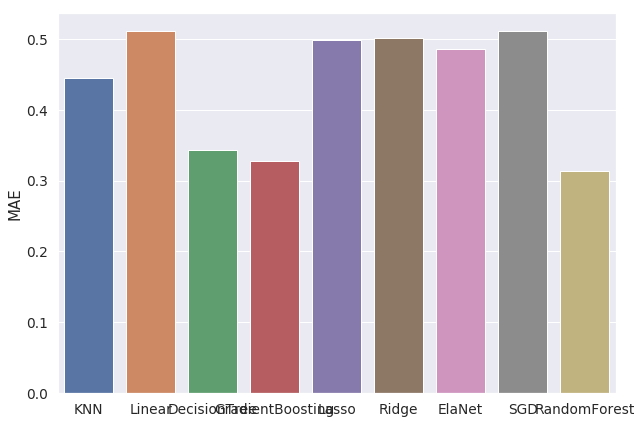

In [203]:
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
sns.barplot(x=list_regressors, y=list_mae, ax=ax)
plt.ylabel('MAE')
plt.show()

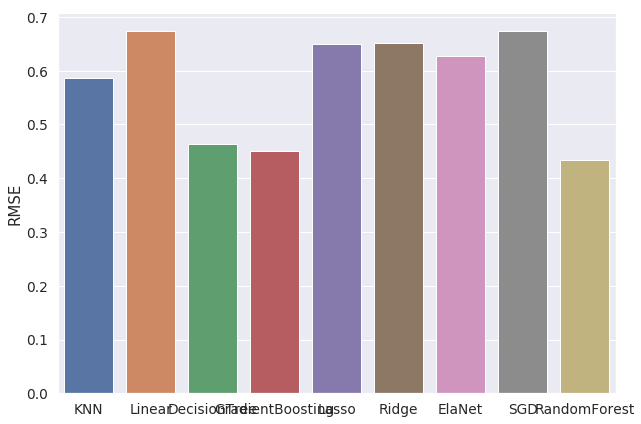

In [204]:
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
sns.barplot(x=list_regressors, y=list_rmse, ax=ax)
plt.ylabel('RMSE')
plt.show()

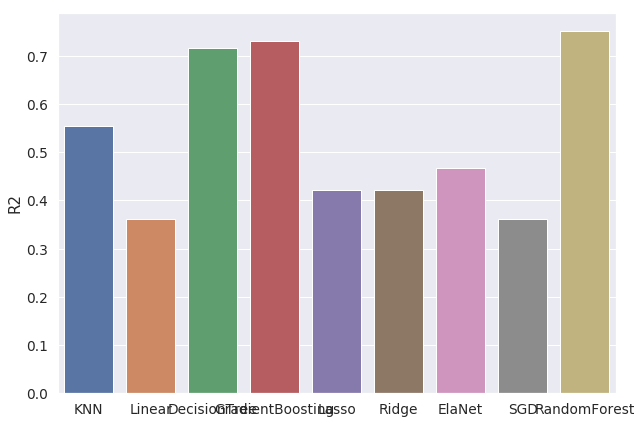

In [205]:
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
sns.barplot(x=list_regressors, y=list_r2, ax=ax)
plt.ylabel('R2')
plt.show()

In [206]:
rfr_best_params.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=5, verbose=0, warm_start=False)

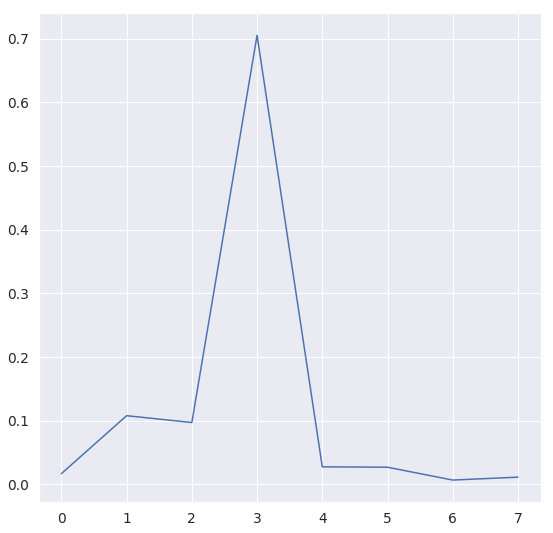

In [207]:
plt.plot(rfr_best_params.feature_importances_)

In [212]:
X.columns[rfr_best_params.feature_importances_>0.09]

array(['Net_Incomes_log', 'Net_Incomes', 'Clics'], dtype=object)

In [ ]:
# feature importance de categorias
# lo mismo con rolling y sin rolloing